This notebook is the sequel of a [previous iteration]() where I explored the stranding dataset, and developed some models where the stranding is conditional on seasonality. Here, I explore the possible use of all available + some engineered features. I summarize geophysical data using monthly means and standard deviation to model it. For some of the features I compute 1-month lags summarized as above. I then proceed to model the data using two approaches;  Zero-Inflated Poisson (ZIP) and Zero-Inflated Negative Binomial (ZINB). Bayesian models don't overfit since they don't maximize likelihood. However, for the sake of enabling comparisons of these results with frequentist approaches, I split the dataset into training and test sets.

In [1]:
import pathlib
import pickle
import sys
import warnings
from seaborn import heatmap, stripplot
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from theano import tensor as tt
from theano import shared
from cmocean.cm import thermal, balance_r

/home/madhatter106/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home/madhatter106/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home/madhatter106/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home/madhatter106/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home/madhatter106/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated i

### 1 - Data Exploration, Transformation, and Feature Engineering
Let's take a look at the data first. Note that for this tranche I don't use census data as, a priori, they appear to introduce more complications than statistical power. An examination of the potential effect of using census data is left for another day. I also group all animals, since there is no reason to believe at this point that the environmental conditions quantified by the predictive features I use here affect different species differently. A study of species-specific outcomes will be the subject of a future effort.

In [2]:
# graphical setup
% matplotlib inline
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['font.size'] = 16

In [4]:
print('Version Info', end='\n\n')

print(f'System: {sys.version}')
print('-' * 75)
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'PyMC3: {pm.__version__}')

Version Info

System: 3.6.5 |Anaconda custom (64-bit)| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
---------------------------------------------------------------------------
pandas: 0.23.1
numpy: 1.14.5
PyMC3: 3.4.1


In [5]:
# additional settings
warnings.filterwarnings('ignore')

In [6]:
home = pathlib.Path.home().as_posix()
data_subpath = '/DATA/Beaching_Project/PklJar/'

In [7]:
df_features = pd.read_pickle(f'{home}{data_subpath}DFFEATURES.pkl')
df_targets = pd.read_pickle(f'{home}{data_subpath}DFLABELS.pkl')

df_features.head(3).T

,1999-01-01 00:00:00,1999-01-02 00:00:00,1999-01-03 00:00:00
Ddelph_count,0.000000,0.000000,0.000000
Lageno_count,0.000000,0.000000,0.000000
FRDH,20999.987708,20995.609097,21050.438681
FRDV,49201.519653,49202.668125,52278.752361
OTTH,17459.028474,17455.841440,17458.259553
OTTV,53549.040000,53548.428889,53551.839861
Kp_index,15.750000,17.750000,10.500000
Sunspot_No,89.000000,94.000000,80.000000
Dst_index,-3.333333,-7.458333,-4.125000
AE_index,94.333333,139.875000,59.958333


In [8]:
# Drop census data:
df_features.drop(['Lageno_count', 'Ddelph_count'], axis=1, inplace=True)

In [9]:
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
FRDH,5836.0,22102.885934,7556.868228,20810.878681,21014.314061,21150.557272,21291.375443,141419.942024
FRDV,5824.0,48392.710382,3266.667266,46697.858903,47341.060434,47983.967187,48667.408142,98162.458889
OTTH,5479.0,18596.959816,7379.706478,17351.674429,17633.608423,17811.659804,18052.456247,141419.942024
OTTV,5465.0,52663.105160,1648.741556,51500.003333,52030.123542,52546.232500,53059.596736,94161.155903
Kp_index,5844.0,18.254706,11.497098,0.000000,9.250000,16.375000,25.375000,76.250000
Sunspot_No,5844.0,81.153320,68.474896,0.000000,21.000000,68.000000,128.000000,353.000000
Dst_index,5844.0,-12.441856,18.684852,-220.958333,-18.968750,-8.791667,-1.083333,34.500000
AE_index,5844.0,178.346702,144.305224,7.375000,70.781250,135.541667,246.427083,1111.083333
Proton_flux_gt30MeV,5352.0,2.148805,40.735097,0.057917,0.099167,0.120417,0.276750,1942.000000
Proton_flux_gt60MeV,5352.0,0.825572,14.678992,0.040417,0.068605,0.087083,0.243333,693.083333


In [10]:
df_targets.head(3).T

,1999-01-01 00:00:00,1999-01-02 00:00:00,1999-01-03 00:00:00
NUM_ANIMALS,0.0,0.0,0.0
SPECIES_Delphinus delphis,0.0,0.0,0.0
SPECIES_Globicephala melas,0.0,0.0,0.0
SPECIES_Grampus griseus,0.0,0.0,0.0
SPECIES_Lagenorhynchus acutus,0.0,0.0,0.0
SPECIES_Stenella coeruleoalba,0.0,0.0,0.0
SPECIES_Tursiops truncatus,0.0,0.0,0.0
CONDITION_CODE_1,0.0,0.0,0.0
CONDITION_CODE_2,0.0,0.0,0.0
CONDITION_CODE_3,0.0,0.0,0.0


In [11]:
y_targets = df_targets[['NUM_ANIMALS']]

In [12]:
sun_mag_features = ['FRDH', 'FRDV', 'OTTH', 'OTTV', 'Kp_index', 'Sunspot_No', 'AE_index', 'Dst_index',
           'Proton_flux_gt30MeV', 'Proton_flux_gt60MeV']
water_features = ['EasterlyWS', 'SoutherlyWS', 'WTMP', 'WVHT', 'APD', 'DPD']

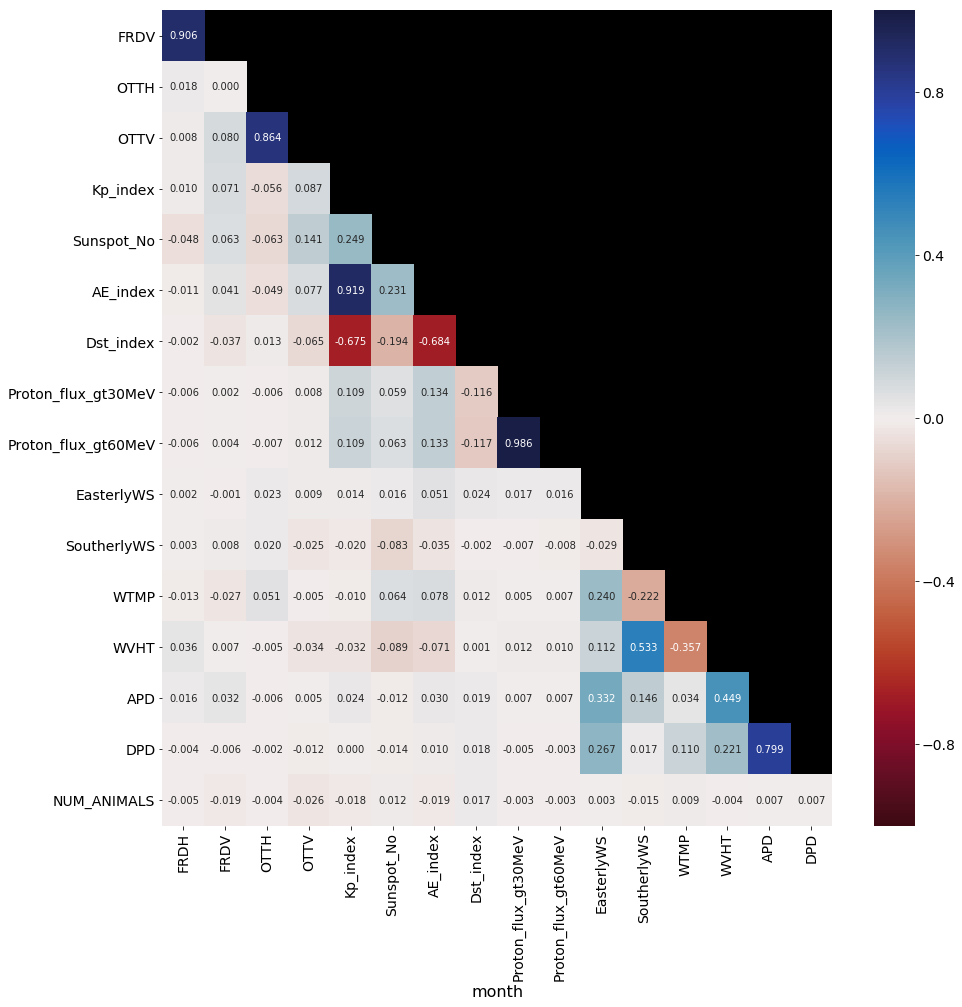

In [13]:
# and graphically
_, ax = pl.subplots(figsize=(15,15))
features = sun_mag_features + water_features
df = pd.concat((df_features[features], y_targets), axis=1)

heatmap(df.corr().iloc[1:, :-1], annot=True, annot_kws=dict(fontsize=10), fmt='.3f',
        ax=ax, cmap=balance_r, vmin=-1, vmax=1, mask=np.triu(np.ones([len(features)]*2), k=1));
ax.set_xlabel('month');
ax.set_facecolor('black')

FRDH and FRDV are higly correlated - take their L2 norm
AE_index Dst_index are higly correlated, pick one
proton flux 30/60 are highly correlated, pick one.

In [14]:
df_features['FRD_Norm'] = np.sqrt(df_features['FRDH'] ** 2 + df_features['FRDV'] ** 2)
df_features['OTT_Norm'] = np.sqrt(df_features['OTTH'] ** 2 + df_features['OTTV'] ** 2)

In [15]:
df_features.drop('Proton_flux_gt60MeV', axis=1, inplace=True)

In [16]:
df_features.drop(['OTTH' ,'OTTV', 'FRDH', 'FRDV'], axis=1, inplace=True)

In [17]:
df_features.drop(['AE_index'], axis=1, inplace=True)

In [18]:
new_sun_mag_features = ['FRD_Norm', 'OTT_Norm', 'Kp_index',
                    'Sunspot_No', 'Dst_index', 'Proton_flux_gt30MeV',]
new_water_features = ['EasterlyWS', 'SoutherlyWS', 'WTMP', 'WVHT', 'APD', 'DPD']
new_features = new_sun_mag_features + new_water_features

In [19]:
df_feats = df_features[new_features]

In [20]:
df_feats_stdized = (df_feats - df_feats.mean(axis=0)) / df_feats.std(axis=0)

In [47]:
df_feats_stdized.describe().T

,count,mean,std,min,25%,50%,75%,max
FRD_Norm,5824.0,-2.811927e-14,1.0,-0.305004,-0.216114,-0.127183,-0.032057,18.950599
OTT_Norm,5465.0,-4.411141e-14,1.0,-0.339000,-0.214835,-0.077801,0.041507,28.866183
Kp_index,5844.0,-1.380762e-16,1.0,-1.587766,-0.783216,-0.163494,0.619312,5.044342
Sunspot_No,5844.0,-3.518888e-16,1.0,-1.185154,-0.878473,-0.192090,0.684144,3.970020
Dst_index,5844.0,1.294139e-15,1.0,-11.159654,-0.349315,0.195356,0.607900,2.512295
Proton_flux_gt30MeV,5352.0,-2.389718e-17,1.0,-0.051329,-0.050316,-0.049795,-0.045957,47.621126
EasterlyWS,5397.0,-7.808795e-17,1.0,-3.475342,-0.574587,0.114824,0.636475,3.813558
SoutherlyWS,5397.0,9.819621e-17,1.0,-2.541268,-0.746093,-0.116447,0.664581,4.594359
WTMP,5394.0,1.743980e-15,1.0,-1.814311,-0.947861,-0.087847,0.968157,2.193823
WVHT,5365.0,2.433241e-15,1.0,-1.207735,-0.634323,-0.293405,0.279061,8.722757


In [21]:
df_feat_monthly_mean = df_feats_stdized.resample('M').mean()
df_feat_monthly_std = df_feats_stdized.resample('M').std()
df_feat_monthly = pd.merge(df_feat_monthly_mean, df_feat_monthly_std, how='outer',
                           left_index=True, right_index=True, suffixes=('_mean', '_std'))

In [22]:
df_feat_monthly.insert(0, 'Month', df_feat_monthly.index.month)

In [23]:
df_feat_monthly.insert(0, 'sin_month', np.sin((df_feat_monthly.Month-1) * 2 * np.pi / 11))
df_feat_monthly.insert(0, 'cos_month', np.cos((df_feat_monthly.Month-1) * 2 * np.pi / 11))

In [24]:
df_feat_monthly.drop('Month', axis=1, inplace=True)

In [48]:
df_feat_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
cos_month,192.0,8.333333e-02,0.733159,-0.959493,-0.654861,1.365501e-01,0.841254,1.000000
sin_month,192.0,-7.239934e-17,0.678773,-0.989821,-0.594418,-5.665539e-16,0.594418,0.989821
FRD_Norm_mean,192.0,5.108032e-03,0.354397,-0.304011,-0.193674,-8.590162e-02,0.043133,2.462258
OTT_Norm_mean,180.0,2.727718e-03,0.283201,-0.335302,-0.176760,-3.386955e-02,0.084437,1.288479
Kp_index_mean,192.0,-3.098331e-05,0.537317,-1.203728,-0.382343,-7.107930e-02,0.319944,1.436910
Sunspot_No_mean,192.0,-9.062966e-04,0.893150,-1.185154,-0.836110,-7.052404e-02,0.615011,2.382906
Dst_index_mean,192.0,-3.372148e-04,0.530312,-2.174168,-0.239382,9.569446e-02,0.371038,1.110758
Proton_flux_gt30MeV_mean,181.0,1.231986e-04,0.235386,-0.051055,-0.050073,-4.925392e-02,-0.041996,1.752555
EasterlyWS_mean,183.0,-4.973209e-03,0.430001,-1.361593,-0.319697,1.257544e-01,0.320437,0.727288
SoutherlyWS_mean,183.0,-5.184221e-03,0.329920,-0.695842,-0.247981,-6.626781e-02,0.225566,0.803792


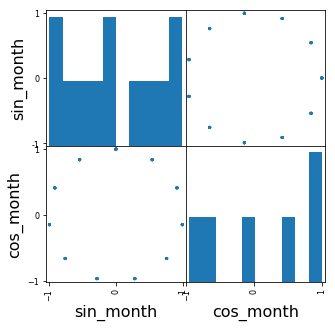

In [25]:
scatter_matrix(df_feat_monthly[['sin_month', 'cos_month']], figsize=(5, 5));

In [62]:
y_targets['event_observed'] = y_targets.NUM_ANIMALS>0

In [69]:
y_targets.event_observed = y_targets.event_observed.astype('category').cat.codes

In [70]:
y_targets.describe()

,NUM_ANIMALS,event_observed
count,5844.000000,5844.000000
mean,0.637748,0.028063
std,10.904013,0.165167
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,484.000000,1.000000


In [68]:
y_monthly = y_targets.resample('M').sum()

In [72]:
y_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
NUM_ANIMALS,192.0,19.411458,122.933909,0.0,0.0,0.0,4.25,1536.0
event_observed,192.0,0.854167,1.742473,0.0,0.0,0.0,1.00,10.0


In [74]:
y_monthly.rename(columns={'NUM_ANIMALS': 'n_indiv_monthly', 
                         'event_observed': 'n_event_monthly'}, inplace=True)

In [75]:
y_monthly.n_event_monthly.value_counts()

0     120
1      43
2      10
4       7
6       4
3       4
10      2
9       1
8       1
Name: n_event_monthly, dtype: int64

In [76]:
y_monthly.describe()

,n_indiv_monthly,n_event_monthly
count,192.000000,192.000000
mean,19.411458,0.854167
std,122.933909,1.742473
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,4.250000,1.000000
max,1536.000000,10.000000


In [119]:
df_feat_monthly.describe().T


,count,mean,std,min,25%,50%,75%,max
cos_month,192.0,8.333333e-02,0.733159,-0.959493,-0.654861,1.365501e-01,0.841254,1.000000
sin_month,192.0,-7.239934e-17,0.678773,-0.989821,-0.594418,-5.665539e-16,0.594418,0.989821
FRD_Norm_mean,192.0,5.108032e-03,0.354397,-0.304011,-0.193674,-8.590162e-02,0.043133,2.462258
OTT_Norm_mean,180.0,2.727718e-03,0.283201,-0.335302,-0.176760,-3.386955e-02,0.084437,1.288479
Kp_index_mean,192.0,-3.098331e-05,0.537317,-1.203728,-0.382343,-7.107930e-02,0.319944,1.436910
Sunspot_No_mean,192.0,-9.062966e-04,0.893150,-1.185154,-0.836110,-7.052404e-02,0.615011,2.382906
Dst_index_mean,192.0,-3.372148e-04,0.530312,-2.174168,-0.239382,9.569446e-02,0.371038,1.110758
Proton_flux_gt30MeV_mean,181.0,1.231986e-04,0.235386,-0.051055,-0.050073,-4.925392e-02,-0.041996,1.752555
EasterlyWS_mean,183.0,-4.973209e-03,0.430001,-1.361593,-0.319697,1.257544e-01,0.320437,0.727288
SoutherlyWS_mean,183.0,-5.184221e-03,0.329920,-0.695842,-0.247981,-6.626781e-02,0.225566,0.803792


In [121]:
df_feat_monthly_mean = df_feat_monthly.loc[:, :'DPD_mean']
df_feat_monthly_mean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 1999-01-31 to 2014-12-31
Freq: M
Data columns (total 14 columns):
cos_month                   192 non-null float64
sin_month                   192 non-null float64
FRD_Norm_mean               192 non-null float64
OTT_Norm_mean               180 non-null float64
Kp_index_mean               192 non-null float64
Sunspot_No_mean             192 non-null float64
Dst_index_mean              192 non-null float64
Proton_flux_gt30MeV_mean    181 non-null float64
EasterlyWS_mean             183 non-null float64
SoutherlyWS_mean            183 non-null float64
WTMP_mean                   183 non-null float64
WVHT_mean                   183 non-null float64
APD_mean                    183 non-null float64
DPD_mean                    183 non-null float64
dtypes: float64(14)
memory usage: 27.5 KB


In [122]:
df_all = pd.merge(df_feat_monthly_mean, y_monthly, how='outer',
                  left_index=True, right_index=True)

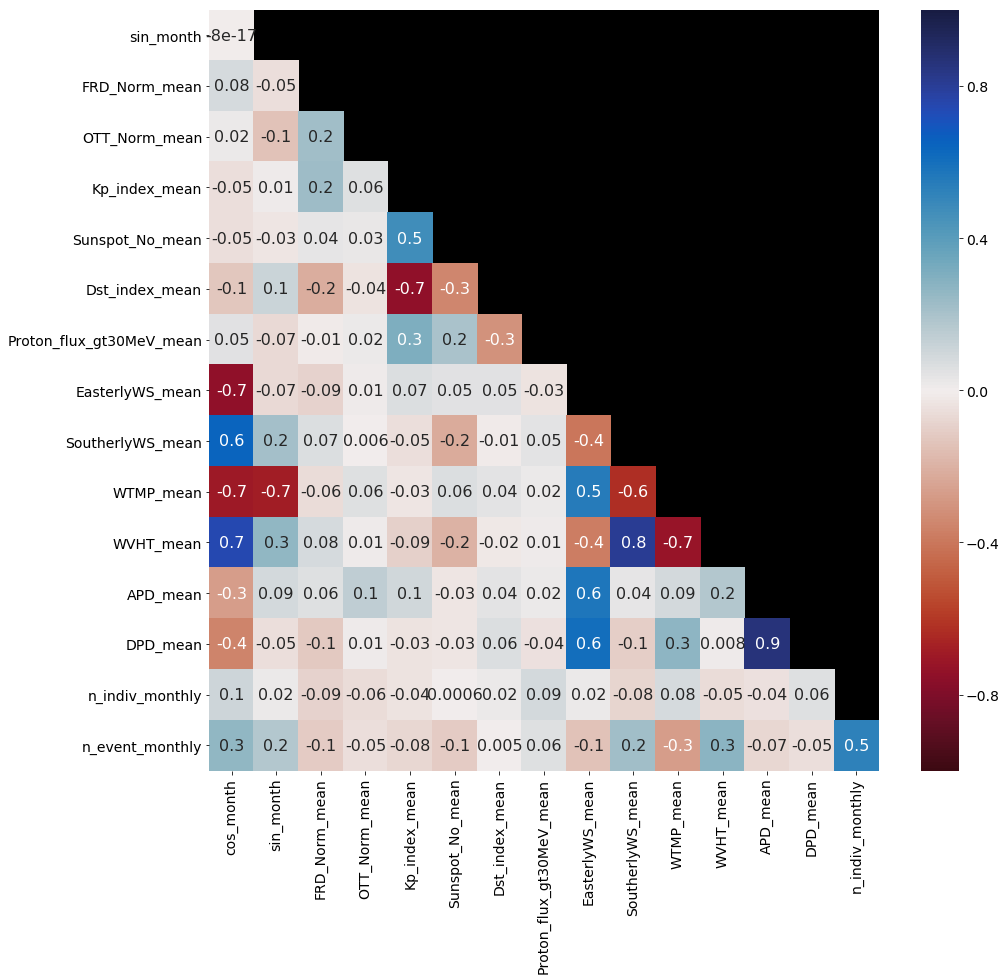

In [123]:
_, ax = pl.subplots(figsize=(15, 14))
heatmap(df_all.corr().iloc[1:, :-1], vmin=-1, vmax=1, cmap=balance_r, annot=True, ax=ax, 
       mask=np.triu(np.ones([df_all.shape[1]-1]*2), k=1), fmt='.1g')
ax.set_facecolor('k')

In [138]:
df_all.drop(['OTT_Norm_mean', 'cos_month', 'sin_month'], axis=1).dropna().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172 entries, 1999-01-31 to 2014-12-31
Data columns (total 13 columns):
FRD_Norm_mean               172 non-null float64
Kp_index_mean               172 non-null float64
Sunspot_No_mean             172 non-null float64
Dst_index_mean              172 non-null float64
Proton_flux_gt30MeV_mean    172 non-null float64
EasterlyWS_mean             172 non-null float64
SoutherlyWS_mean            172 non-null float64
WTMP_mean                   172 non-null float64
WVHT_mean                   172 non-null float64
APD_mean                    172 non-null float64
DPD_mean                    172 non-null float64
n_indiv_monthly             172 non-null float64
n_event_monthly             172 non-null int8
dtypes: float64(12), int8(1)
memory usage: 17.6 KB


In [181]:
df_all.insert_etc
df_all['EasterlyWS_mean_lag_1'] = df_all.EasterlyWS_mean.shift()
df_all['SoutherlyWS_mean_lag_1'] = df_all.SoutherlyWS_mean.shift()

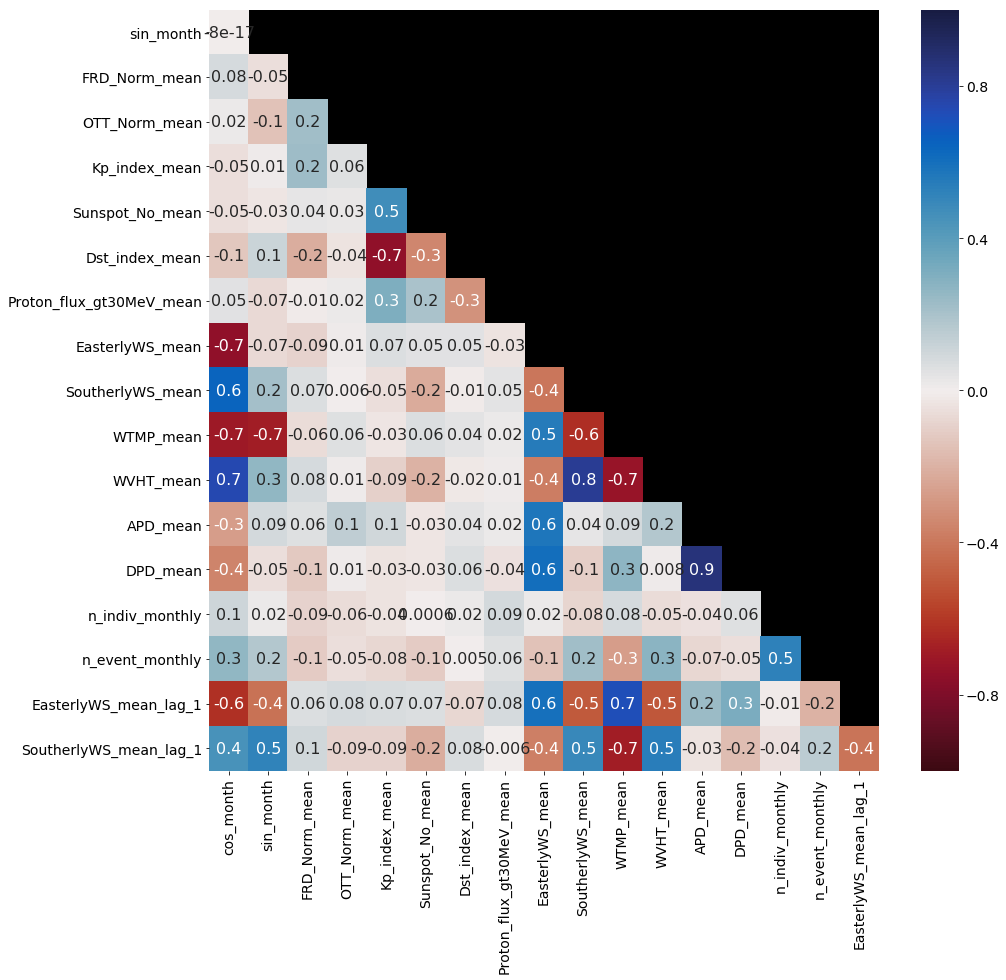

In [182]:
_, ax = pl.subplots(figsize=(15, 14))
heatmap(df_all.corr().iloc[1:, :-1], vmin=-1, vmax=1, cmap=balance_r, annot=True, ax=ax, 
       mask=np.triu(np.ones([df_all.shape[1]-1]*2), k=1), fmt='.1g')
ax.set_facecolor('k')

In [184]:
drop_em = ['OTT_Norm_mean', 'cos_month', 'sin_month', 'APD_mean',
           'Proton_flux_gt30MeV_mean', 'DPD_mean', 'SoutherlyWS_mean', 'EasterlyWS_mean']
x_data = df_all.drop(drop_em, axis=1).dropna().iloc[:, :-2]

In [190]:
x_data.describe().T

,count,mean,std,min,25%,50%,75%,max
FRD_Norm_mean,179.0,0.007571,0.359072,-0.304011,-0.190870,-0.087086,0.044461,2.462258
Kp_index_mean,179.0,-0.001380,0.547155,-1.203728,-0.400562,-0.071956,0.324299,1.436910
Sunspot_No_mean,179.0,-0.006442,0.908429,-1.185154,-0.866381,-0.093160,0.639154,2.382906
Dst_index_mean,179.0,0.009314,0.526968,-2.174168,-0.222354,0.096940,0.385227,1.110758
WTMP_mean,179.0,-0.001218,0.983110,-1.528485,-0.936513,-0.116305,0.989340,1.738758
WVHT_mean,179.0,-0.006533,0.464268,-0.817280,-0.394106,-0.026398,0.362797,1.294171
n_indiv_monthly,179.0,7.726257,26.737970,0.000000,0.000000,0.000000,4.000000,273.000000
n_event_monthly,179.0,0.748603,1.490960,0.000000,0.000000,0.000000,1.000000,10.000000


In [186]:
y_data = df_all.drop(drop_em, axis=1).dropna().n_event_monthly

In [187]:
X_shared = shared(x_data.values)
X_ = pm.floatX(X_shared)
#y_shared = shared(y_data.values)
#Y_ = pm.floatX(y_shared)

In [188]:
n_feats = X_.eval().shape[1]
with pm.Model() as laplace_1_poisson:
    alpha = pm.Normal('alpha', 0, sd=1)
    beta = pm.Normal('beta', 0, sd=1, shape=n_feats)
    psi = pm.Beta('psi', 1, 1)
    lam = pm.Deterministic('theta', pm.math.exp(alpha + pm.math.dot(X_, beta)))
    num_events = pm.ZeroInflatedPoisson('likelihood', psi=psi,
                                        theta=lam, observed=y_data.values)

In [189]:
with laplace_1_poisson:
    trace_1_poisson = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [psi_logodds__, beta, alpha]
  1%|          | 37/4000 [00:00<00:10, 369.27it/s]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7fc11fa09db0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/madhatter106/anaconda3/lib/python3.6/site-...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/madhatter106/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/madhat.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7fc11fa09db0, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/madhatter106/anaconda3/lib/python3.6/site-...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/madhatter106/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/madhat.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'with laplace_1_poisson:\n    trace_1_poisson = pm.sample(2000, tune=2000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 2, 21, 19, 6, 970243, tzinfo=tzutc()), 'msg_id': '1F03DC56A7724044A83368BBF7FFE153', 'msg_type': 'execute_request', 'session': 'B5BEC38FF32B4AF8AA6E7B925D54C9C2', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '1F03DC56A7724044A83368BBF7FFE153', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'B5BEC38FF32B4AF8AA6E7B925D54C9C2']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'with laplace_1_poisson:\n    trace_1_poisson = pm.sample(2000, tune=2000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 2, 21, 19, 6, 970243, tzinfo=tzutc()), 'msg_id': '1F03DC56A7724044A83368BBF7FFE153', 'msg_type': 'execute_request', 'session': 'B5BEC38FF32B4AF8AA6E7B925D54C9C2', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '1F03DC56A7724044A83368BBF7FFE153', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'B5BEC38FF32B4AF8AA6E7B925D54C9C2'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'with laplace_1_poisson:\n    trace_1_poisson = pm.sample(2000, tune=2000)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 2, 21, 19, 6, 970243, tzinfo=tzutc()), 'msg_id': '1F03DC56A7724044A83368BBF7FFE153', 'msg_type': 'execute_request', 'session': 'B5BEC38FF32B4AF8AA6E7B925D54C9C2', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '1F03DC56A7724044A83368BBF7FFE153', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='with laplace_1_poisson:\n    trace_1_poisson = pm.sample(2000, tune=2000)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'with laplace_1_poisson:\n    trace_1_poisson = pm.sample(2000, tune=2000)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('with laplace_1_poisson:\n    trace_1_poisson = pm.sample(2000, tune=2000)',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('with laplace_1_poisson:\n    trace_1_poisson = pm.sample(2000, tune=2000)',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='with laplace_1_poisson:\n    trace_1_poisson = pm.sample(2000, tune=2000)', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.With object>], cell_name='<ipython-input-189-7ec8ab6d500a>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7fc08c8fc320, executi..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7fc0c7126b70, file "<ipython-input-189-7ec8ab6d500a>", line 1>
        result = <ExecutionResult object at 7fc08c8fc320, executi..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7fc0c7126b70, file "<ipython-input-189-7ec8ab6d500a>", line 1>, result=<ExecutionResult object at 7fc08c8fc320, executi..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7fc0c7126b70, file "<ipython-input-189-7ec8ab6d500a>", line 1>
        self.user_global_ns = {'In': ['', 'import pathlib\nimport pickle\nimport sys\nimport w... shared\nfrom cmocean.cm import thermal, balance_r', "# graphical setup\nget_ipython().magic('matplotli...ytick.labelsize'] = 14\nrcParams['font.size'] = 16", "print('Version Info', end='\\n\\n')\n\nprint(f'Syste....__version__}')\nprint(f'PyMC3: {pm.__version__}')", "print('Version Info', end='\\n\\n')\n\nprint(f'Syste....__version__}')\nprint(f'PyMC3: {pm.__version__}')", "# additional settings\nwarnings.filterwarnings('ignore')", "home = pathlib.Path.home().as_posix()\ndata_subpath = '/DATA/Beaching_Project/PklJar/'", "df_features = pd.read_pickle(f'{home}{data_subpa...ata_subpath}DFLABELS.pkl')\n\ndf_features.head(3).T", "# Drop census data:\ndf_features.drop(['Lageno_count', 'Ddelph_count'], axis=1, inplace=True)", 'df_features.describe().T', 'df_targets.head(3).T', "y_targets = df_targets[['NUM_ANIMALS']]", "sun_mag_features = ['FRDH', 'FRDV', 'OTTH', 'OTT...WS', 'SoutherlyWS', 'WTMP', 'WVHT', 'APD', 'DPD']", "# and graphically\n_, ax = pl.subplots(figsize=(1...ax.set_xlabel('month');\nax.set_facecolor('black')", "df_features['FRD_Norm'] = np.sqrt(df_features['F...features['OTTH'] ** 2 + df_features['OTTV'] ** 2)", "df_features.drop('Proton_flux_gt60MeV', axis=1, inplace=True)", "df_features.drop(['OTTH' ,'OTTV', 'FRDH', 'FRDV'], axis=1, inplace=True)", "df_features.drop(['AE_index'], axis=1, inplace=True)", "new_sun_mag_features = ['FRD_Norm', 'OTT_Norm', ...tures = new_sun_mag_features + new_water_features", 'df_feats = df_features[new_features]', ...], 'Out': {7:                        1999-01-01    1999-01-02 ...             7.372083      4.049167      4.574583, 9:                       count          mean       ...2604      7.071875      8.725966      16.670000  , 10:                                1999-01-01  1999-...                      0.0         0.0         0.0, 30: 0    120
1     72
Name: event_observed, dtype: int64, 31:                           count          mean   ...               9.236687e-01  1.050470  1.478829  , 43: (13, 13), 44: (192, 13), 45: <matplotlib.axes._subplots.AxesSubplot object>, 47:                       count          mean  std  ...5139  
DPD                  0.705473   4.158189  , 48:                           count          mean   ...               9.236687e-01  1.050470  1.478829  , ...}, 'X_': <TensorType(float64, matrix)>, 'X_shared': <TensorType(float64, matrix)>, 'Y_': Elemwise{Cast{float64}}.0, '_': <Figure size 1080x1008 with 2 Axes>, '_10':                                1999-01-01  1999-...                      0.0         0.0         0.0, '_109':             FRD_Norm  Kp_index  Sunspot_No  Prot...  0.0                0  

[170 rows x 10 columns], '_111':             FRD_Norm  Kp_index  Sunspot_No  Prot...747 -0.527856  0.042831  

[172 rows x 8 columns], '_119':                           count          mean   ...               9.236687e-01  1.050470  1.478829  , ...}
        self.user_ns = {'In': ['', 'import pathlib\nimport pickle\nimport sys\nimport w... shared\nfrom cmocean.cm import thermal, balance_r', "# graphical setup\nget_ipython().magic('matplotli...ytick.labelsize'] = 14\nrcParams['font.size'] = 16", "print('Version Info', end='\\n\\n')\n\nprint(f'Syste....__version__}')\nprint(f'PyMC3: {pm.__version__}')", "print('Version Info', end='\\n\\n')\n\nprint(f'Syste....__version__}')\nprint(f'PyMC3: {pm.__version__}')", "# additional settings\nwarnings.filterwarnings('ignore')", "home = pathlib.Path.home().as_posix()\ndata_subpath = '/DATA/Beaching_Project/PklJar/'", "df_features = pd.read_pickle(f'{home}{data_subpa...ata_subpath}DFLABELS.pkl')\n\ndf_features.head(3).T", "# Drop census data:\ndf_features.drop(['Lageno_count', 'Ddelph_count'], axis=1, inplace=True)", 'df_features.describe().T', 'df_targets.head(3).T', "y_targets = df_targets[['NUM_ANIMALS']]", "sun_mag_features = ['FRDH', 'FRDV', 'OTTH', 'OTT...WS', 'SoutherlyWS', 'WTMP', 'WVHT', 'APD', 'DPD']", "# and graphically\n_, ax = pl.subplots(figsize=(1...ax.set_xlabel('month');\nax.set_facecolor('black')", "df_features['FRD_Norm'] = np.sqrt(df_features['F...features['OTTH'] ** 2 + df_features['OTTV'] ** 2)", "df_features.drop('Proton_flux_gt60MeV', axis=1, inplace=True)", "df_features.drop(['OTTH' ,'OTTV', 'FRDH', 'FRDV'], axis=1, inplace=True)", "df_features.drop(['AE_index'], axis=1, inplace=True)", "new_sun_mag_features = ['FRD_Norm', 'OTT_Norm', ...tures = new_sun_mag_features + new_water_features", 'df_feats = df_features[new_features]', ...], 'Out': {7:                        1999-01-01    1999-01-02 ...             7.372083      4.049167      4.574583, 9:                       count          mean       ...2604      7.071875      8.725966      16.670000  , 10:                                1999-01-01  1999-...                      0.0         0.0         0.0, 30: 0    120
1     72
Name: event_observed, dtype: int64, 31:                           count          mean   ...               9.236687e-01  1.050470  1.478829  , 43: (13, 13), 44: (192, 13), 45: <matplotlib.axes._subplots.AxesSubplot object>, 47:                       count          mean  std  ...5139  
DPD                  0.705473   4.158189  , 48:                           count          mean   ...               9.236687e-01  1.050470  1.478829  , ...}, 'X_': <TensorType(float64, matrix)>, 'X_shared': <TensorType(float64, matrix)>, 'Y_': Elemwise{Cast{float64}}.0, '_': <Figure size 1080x1008 with 2 Axes>, '_10':                                1999-01-01  1999-...                      0.0         0.0         0.0, '_109':             FRD_Norm  Kp_index  Sunspot_No  Prot...  0.0                0  

[170 rows x 10 columns], '_111':             FRD_Norm  Kp_index  Sunspot_No  Prot...747 -0.527856  0.042831  

[172 rows x 8 columns], '_119':                           count          mean   ...               9.236687e-01  1.050470  1.478829  , ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
/home/madhatter106/DEV/DATASCIENCEPROJECTS/beaching/notebooks/<ipython-input-189-7ec8ab6d500a> in <module>()
      1 with laplace_1_poisson:
----> 2     trace_1_poisson = pm.sample(2000, tune=2000)

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py in sample(draws=4000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='auto', n_init=200000, start=[{'alpha': array(0.03724532), 'beta': array([-0.07166321, -0.94464011, -0.72057052, -0...1,
       -0.75012085,  0.61327572,  0.68847374]), 'psi_logodds__': array(0.57726599)}, {'alpha': array(0.77244272), 'beta': array([ 0.19082539,  0.59237795, -0.85391663, -0...5,
       -0.64364567,  0.63615448,  0.31132921]), 'psi_logodds__': array(0.92222184)}], trace=None, chain_idx=0, chains=2, cores=2, tune=2000, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=[456780331, 980356549], live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, use_mmap=False, **kwargs={})
    437     parallel = cores > 1 and chains > 1 and not has_population_samplers
    438     if parallel:
    439         _log.info('Multiprocess sampling ({} chains in {} jobs)'.format(chains, cores))
    440         _print_step_hierarchy(step)
    441         try:
--> 442             trace = _mp_sample(**sample_args)
        trace = None
        sample_args = {'chain': 0, 'chains': 2, 'cores': 2, 'draws': 4000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': [456780331, 980356549], 'start': [{'alpha': array(0.03724532), 'beta': array([-0.07166321, -0.94464011, -0.72057052, -0...1,
       -0.75012085,  0.61327572,  0.68847374]), 'psi_logodds__': array(0.57726599)}, {'alpha': array(0.77244272), 'beta': array([ 0.19082539,  0.59237795, -0.85391663, -0...5,
       -0.64364567,  0.63615448,  0.31132921]), 'psi_logodds__': array(0.92222184)}], ...}
    443         except pickle.PickleError:
    444             _log.warning("Could not pickle model, sampling singlethreaded.")
    445             _log.debug('Pickling error:', exec_info=True)
    446             parallel = False

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 4000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 2000})
    977             for args in zip(chain_nums, pbars, rseed, start))
    978 
    979     if use_mmap:
    980         traces = Parallel(n_jobs=cores)(jobs)
    981     else:
--> 982         traces = Parallel(n_jobs=cores, mmap_mode=None)(jobs)
        traces = undefined
        cores = 2
        jobs = <generator object _mp_sample.<locals>.<genexpr>>
    983 
    984     return MultiTrace(traces)
    985 
    986 

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Tue Oct  2 17:19:09 2018
PID: 10866            Python 3.6.5: /home/madhatter106/anaconda3/bin/python
...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (0, True, 456780331, {'alpha': array(0.03724532), 'beta': array([-0.07166321, -0.94464011, -0.72057052, -0...1,
       -0.75012085,  0.61327572,  0.68847374]), 'psi_logodds__': array(0.57726599)}), {'draws': 4000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 2000})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = (0, True, 456780331, {'alpha': array(0.03724532), 'beta': array([-0.07166321, -0.94464011, -0.72057052, -0...1,
       -0.75012085,  0.61327572,  0.68847374]), 'psi_logodds__': array(0.57726599)})
        kwargs = {'draws': 4000, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 2000}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py in _sample(chain=0, progressbar=True, random_seed=456780331, start={'alpha': array(0.03724532), 'beta': array([-0.07166321, -0.94464011, -0.72057052, -0...1,
       -0.75012085,  0.61327572,  0.68847374]), 'psi_logodds__': array(0.57726599)}, draws=4000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, trace=None, tune=2000, model=<pymc3.model.Model object>, live_plot=False, live_plot_kwargs=None, **kwargs={})
    549                             tune, model, random_seed)
    550     if progressbar:
    551         sampling = tqdm(sampling, total=draws)
    552     try:
    553         strace = None
--> 554         for it, strace in enumerate(sampling):
        it = 102
        strace = <pymc3.backends.ndarray.NDArray object>
        sampling =   1%|          | 37/4000 [00:00<00:19, 207.08it/s]
    555             if live_plot:
    556                 if live_plot_kwargs is None:
    557                     live_plot_kwargs = {}
    558                 if it >= skip_first:

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py in __iter__(self=  1%|          | 37/4000 [00:00<00:19, 206.88it/s])
    925             except AttributeError:
    926                 raise TqdmDeprecationWarning("""\
    927 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    928 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    929 
--> 930             for obj in iterable:
        obj = <pymc3.backends.ndarray.NDArray object>
        iterable = <generator object _iter_sample>
    931                 yield obj
    932                 # Update and possibly print the progressbar.
    933                 # Note: does not call self.update(1) for speed optimisation.
    934                 n += 1

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py in _iter_sample(draws=4000, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'alpha': array(0.03724532), 'beta': array([-0.07166321, -0.94464011, -0.72057052, -0...1,
       -0.75012085,  0.61327572,  0.68847374]), 'psi_logodds__': array(0.57726599)}, trace=None, chain=0, tune=2000, model=<pymc3.model.Model object>, random_seed=456780331)
    647         step.tune = bool(tune)
    648         for i in range(draws):
    649             if i == tune:
    650                 step = stop_tuning(step)
    651             if step.generates_stats:
--> 652                 point, states = step.step(point)
        point = {'alpha': array(0.03724532), 'beta': array([-0.07166321, -0.94464011, -0.72057052, -0...1,
       -0.75012085,  0.61327572,  0.68847374]), 'psi_logodds__': array(0.57726599)}
        states = [{'depth': 1, 'diverging': True, 'energy': 3.581729975271796e+73, 'energy_error': 0.0, 'max_energy_error': 6.277101735386681e+57, 'mean_tree_accept': 0.0, 'step_size': 1.0701497613081512e-47, 'step_size_bar': 1.7897224411416143e-45, 'tree_size': 1, 'tune': True}]
        step.step = <bound method GradientSharedStep.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    653                 if strace.supports_sampler_stats:
    654                     strace.record(point, states)
    655                 else:
    656                     strace.record(point)

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'alpha': array(0.03724532), 'beta': array([-0.07166321, -0.94464011, -0.72057052, -0...1,
       -0.75012085,  0.61327572,  0.68847374]), 'psi_logodds__': array(0.57726599)})
    217     def step(self, point):
    218         self._logp_dlogp_func.set_extra_values(point)
    219         array = self._logp_dlogp_func.dict_to_array(point)
    220 
    221         if self.generates_stats:
--> 222             apoint, stats = self.astep(array)
        apoint = undefined
        stats = undefined
        self.astep = <bound method BaseHMC.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        array = array([ 0.57726599, -0.07166321, -0.94464011, -0...75012085,  0.61327572,  0.68847374,  0.03724532])
    223             point = self._logp_dlogp_func.array_to_full_dict(apoint)
    224             return point, stats
    225         else:
    226             apoint = self.astep(array)

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/base_hmc.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([ 0.57726599, -0.07166321, -0.94464011, -0...75012085,  0.61327572,  0.68847374,  0.03724532]))
    110         """Perform a single HMC iteration."""
    111         p0 = self.potential.random()
    112         start = self.integrator.compute_state(q0, p0)
    113 
    114         if not np.isfinite(start.energy):
--> 115             self.potential.raise_ok()
        self.potential.raise_ok = <bound method QuadPotentialDiagAdapt.raise_ok of...hmc.quadpotential.QuadPotentialDiagAdapt object>>
    116             raise ValueError('Bad initial energy: %s. The model '
    117                              'might be misspecified.' % start.energy)
    118 
    119         adapt_step = self.tune and self.adapt_step_size

...........................................................................
/home/madhatter106/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/quadpotential.py in raise_ok(self=<pymc3.step_methods.hmc.quadpotential.QuadPotentialDiagAdapt object>)
    185 
    186         self._n_samples += 1
    187 
    188     def raise_ok(self):
    189         if np.any(self._stds == 0):
--> 190             raise ValueError('Mass matrix contains zeros on the diagonal. '
    191                              'Some derivatives might always be zero.')
    192         if np.any(self._stds < 0):
    193             raise ValueError('Mass matrix contains negative values on the '
    194                              'diagonal.')

ValueError: Mass matrix contains zeros on the diagonal. Some derivatives might always be zero.
___________________________________________________________________________

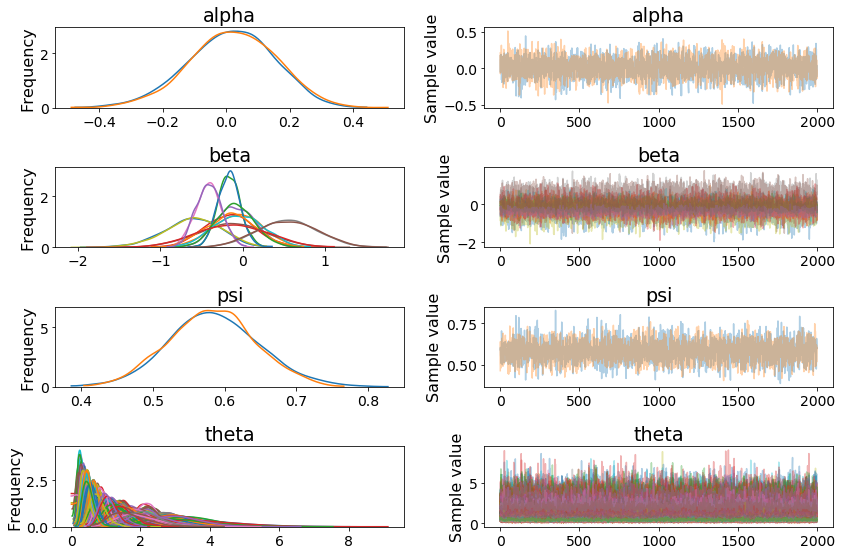

In [178]:
pm.traceplot(trace_1_poisson);

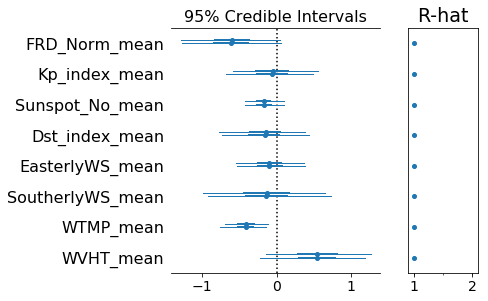

In [179]:
pm.forestplot(trace_1_poisson, varnames=['beta'], ylabels=x_data.columns);

In [12]:
# GET MODEL POSTERIOR BY MONTH
alpha_month_post = trace_mpp1.get_values('alpha_month', combine=True)
lambda_mpp1_post = np.exp(alpha_month_post)
expected_alpha_mpp1 = np.mean(lambda_mpp1_post, axis=0)
hpd_95_lambda_mpp1_post = pm.hpd(lambda_mpp1_post)
df_mpp1 = pd.DataFrame(np.c_[expected_alpha_mpp1, hpd_95_lambda_mpp1_post], columns=['exp_mdl', 'hpd95_lo', 'hpd95_hi'])

# GET MODEL POSTERIOR
lambda_mpp1_post_ = np.exp(alpha_month_post[:,df_T_M.month])
expected_lambda_mpp1_ = np.mean(lambda_mpp1_post_, axis=0)
hpd_95_lambda_mpp1_post_ = pm.hpd(lambda_mpp1_post_)

# GET POSTERIOR PREDICTIVE CHECK
ppc_mpp1 = pm.sample_ppc(trace_mpp1, model=mpp_1, progressbar=False)['events'] # get ppc for mp_0
# compute 95% credibility intervals of ppc
hpd_95_ppc_mpp1 = pm.hpd(ppc_mpp1)
expected_ppc_mpp1 = np.mean(ppc_mpp1, axis=0)

In [13]:
df_mpp1['expected_ppc'] = expected_ppc_mpp1[10:22]
df_mpp1['hpd95_ppc_lo'] = hpd_95_ppc_mpp1[10:22, 0]
df_mpp1['hpd95_ppc_hi'] = hpd_95_ppc_mpp1[10:22, 1]

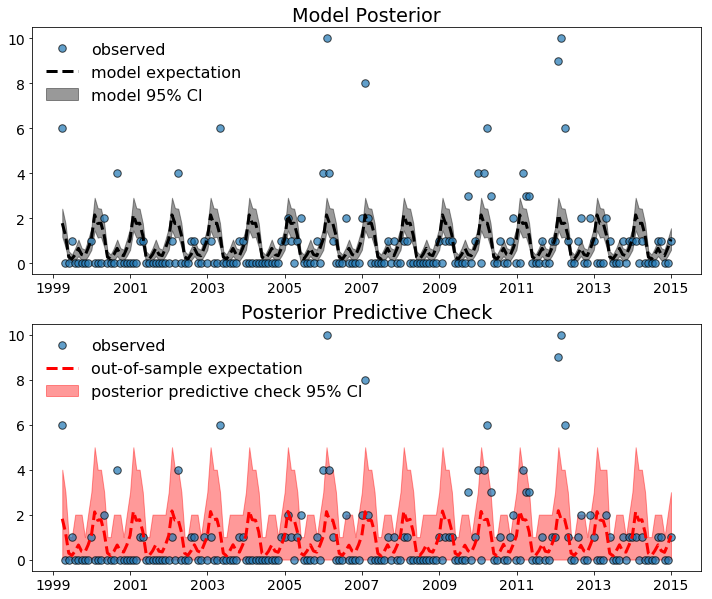

In [17]:
dates = np.array(df_T_M.index.to_pydatetime())
_, ax = pl.subplots(nrows=2, figsize=(12, 10))
ax[0].plot(dates, df_T_M.event, marker='.', markersize=15,
        markeredgecolor='k', ls='', label='observed', alpha=0.7)
ax[0].plot(dates, expected_lambda_mpp1_.T, color='k', ls='--', lw=3,
        label='model expectation')
ax[0].fill_between(dates, y1=hpd_95_lambda_mpp1_post_[:,0],
                y2=hpd_95_lambda_mpp1_post_[:, 1], color='k', alpha=0.4,
               label='model 95% CI');
ax[0].set_title('Model Posterior')
ax[0].legend(framealpha=0)                   
ax[1].plot(dates, df_T_M.event, marker='.', markersize=15,
        markeredgecolor='k', ls='', label='observed', alpha=0.7)
ax[1].plot(dates, expected_ppc_mpp1, ls='--', color='r', lw=3, 
        label='out-of-sample expectation')
ax[1].fill_between(dates, y1=hpd_95_ppc_mpp1[:, 0], y2=hpd_95_ppc_mpp1[:, 1], color='red',
               alpha=0.4, label='posterior predictive check 95% CI')
ax[1].set_title('Posterior Predictive Check')
ax[1].legend(framealpha=0);

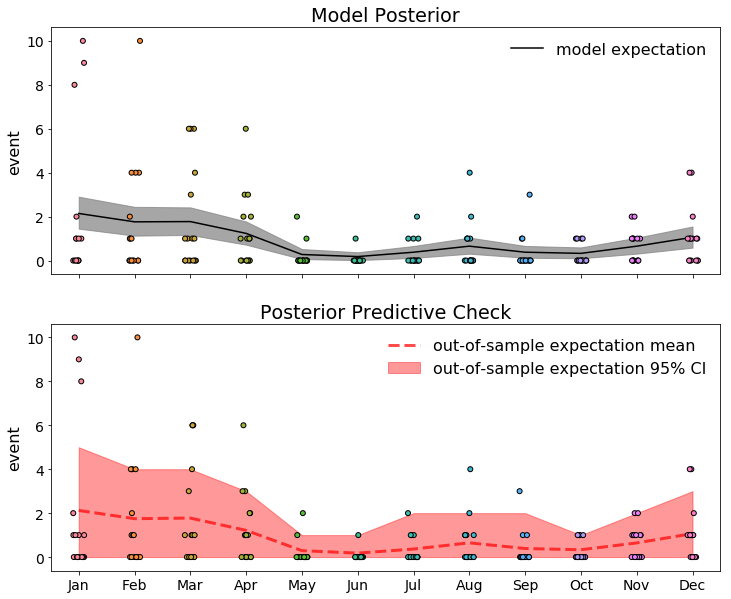

In [22]:
_, ax = pl.subplots(nrows=2, figsize=(12,10), sharex=True)
stripplot(x='month_name', y='event', data=df_T_M.sort_values('month'), ax=ax[0], jitter=True,
         edgecolor='k', linewidth=1)
ax[0].plot(df_mpp1.exp_mdl, color='k', label='model expectation')
ax[0].fill_between(df_mpp1.index, y1=df_mpp1.hpd95_lo, y2=df_mpp1.hpd95_hi, alpha=0.7, color='gray');
ax[0].set_title('Model Posterior')
ax[0].set_xlabel('')
ax[0].legend(framealpha=0)
stripplot(x='month_name', y='event', data=df_T_M.sort_values('month'), ax=ax[1], jitter=True,
         edgecolor='k', linewidth=1)
ax[1].plot(df_mpp1.expected_ppc, ls='--', lw=3, color='r', label='out-of-sample expectation mean', alpha=0.7)
ax[1].fill_between(df_mpp1.index, y1=df_mpp1.hpd95_ppc_lo, y2=df_mpp1.hpd95_ppc_hi, color='red',
               alpha=0.4, label='out-of-sample expectation 95% CI')
ax[1].set_xlabel('')
ax[1].set_title('Posterior Predictive Check')
ax[1].legend(framealpha=0);

Now, we can add predictors to our model and see how well we improve. One remaining problem is that the zero-event may be inflated. This may arise because often there is more than one reason for not observing an event, even if the necessary or threshold conditions have been satisfied. In the case of count data such as these, this can be addressed by using a zero-inflated poisson process, where the 0-event is parameterized separately from the non-zero event. This is an example of a mixture model the exploration of which, in the context of this data, will be the subject of subsequent notebooks along with the use of additional features (predictor variables).

### The Zero-Inflated Poisson (ZIP) Model